In [2]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.path.append('../repo/d-script/')
# d-script imports
from data_iters.minibatcher import MiniBatcher
from data_iters.iam_hdf5_iterator import IAM_MiniBatcher

Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)


### Word level document sharding
#### Be sure to set use_form=True due to HDF5 structure

In [3]:
hdf5_file = h5py.File('../docingest/lines.hdf5','r')
author_hdf5_file = h5py.File('../docingest/author_lines.hdf5','r')
file_list = hdf5_file.keys()
num_authors=64
# num_forms_per_author=-1
num_forms_per_author=500
shingle_dim=(120,1909)
shingle_dim=(120,120)
use_form=True

batch_size=32
lr = 0.01
total_iters=1000

### Call the minibatcher and check the data

In [115]:
# Get a shingle from a line with dimension shingle_dim
def get_shingle(original_line, shingle_dim):
    # Pull shingle from the line
    (height, width) = original_line.shape
    max_x = max(width - shingle_dim[1], 0)
    max_y = max(height - shingle_dim[0], 0)
    x_start = random.randint(0, max_x)
    y_start = random.randint(0, max_y)
    if width < shingle_dim[1] or height < shingle_dim[0]: # The line is too small in at least one access
        output_arr = np.zeros(shingle_dim)
        output_arr.fill(255)
        output_arr[:height,:width] = original_line[:min(height, shingle_dim[0]), :min(width, shingle_dim[1])]
        return output_arr
    else:
        return original_line[y_start:y_start+ shingle_dim[0], x_start:x_start+shingle_dim[1]]

# Return a list of authors with at least min_records number of lines
def author_list(author_hdf5_file, min_records=-1):
    author_list = author_hdf5_file.keys()
    author_num = 0
    author_ids = {}
    for authors in author_list:
        num_records = len( author_hdf5_file[authors].keys() )
        if num_records > min_records:
            author_ids[authors] = author_num
            author_num += 1
    print "There are "+str(author_num)+" authors with "+str(min_records)+" records."
    return author_ids

# From a dictionary, get a random sample
def sample_dictionary( the_dict ):
    keys = the_dict.keys()
    sampleno = np.random.randint(0, len(keys))
    randkey = keys[sampleno]
    return the_dict[ randkey ]

# From an HDF5 file, a list of author ID's, return a minibatch
def get_batch( author_hdf5_file, author_ids, shingle_size=(120,120), data_size=32 ):
    
    author_keys = author_ids.keys()
    author_rands = np.random.randint(0, len(author_keys), data_size)

    author_batch = np.zeros( (data_size, shingle_size[0], shingle_size[1]))
    author_truth = np.zeros( data_size )
    for i, author_rand in enumerate(author_rands):
        author_group = author_hdf5_file[ author_keys[author_rand] ]
        author_batch[i,:,:] = get_shingle( sample_dictionary( author_group ).value , shingle_size)
        author_truth[i] = author_ids[ author_keys[author_rand] ]
        
    return author_batch, author_truth

### Setup batch system to get authors

In [116]:
author_hdf5_file = h5py.File('../docingest/author_lines.hdf5','r')
author_ids = author_list(author_hdf5_file, min_records=50)
author_batch, author_truth = get_batch( author_hdf5_file, author_ids )
num_authors = len(author_ids)

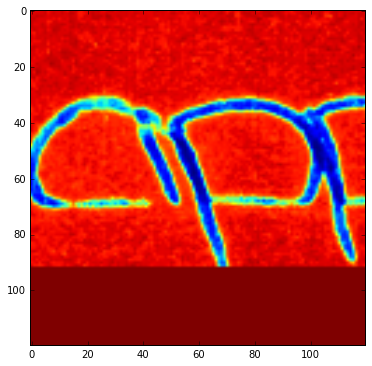

In [117]:
# record = file_list[np.random.randint(0,len(file_list))]
# im = hdf5_file[ record ].value
shards, authors = get_batch(author_hdf5_file, author_ids)
shard = shards[0]

plt.figure(num=None, figsize=(8, 6), dpi=180, facecolor='w', edgecolor='k')
plt.imshow(shard)
# plt.figure(num=None, figsize=(16, 12), dpi=180, facecolor='w', edgecolor='k')
# plt.imshow(im)

### Build the neural network model

In [118]:
if True:
    model = Sequential()
    model.add(Convolution2D(48, 12, 12,
                        border_mode='valid',
                        input_shape=(1, shingle_dim[0], shingle_dim[1])))

    model.add(BN())
    #model.add(PReLU())
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 6, 6))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))

    model.add(Convolution2D(128, 6, 6, border_mode = 'valid'))
    model.add(BN())
    model.add(Activation('relu'))
    #    model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #    #model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode = 'valid'))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BN())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    model.add(Dense(num_authors))
    model.add(Activation('softmax'))

    print "Compiling model"
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.7, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    print "Finished compilation"


if False:
    model = Sequential()
    model.add(Convolution2D(48, 12, 12,
                        border_mode='valid',
                        input_shape=(1, shingle_dim[0], shingle_dim[1]),
                        activation='relu'))

    model.add(Convolution2D(48, 6, 6, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 6, 6, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Convolution2D(128, 4, 4, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_authors))
    model.add(Activation('softmax'))

    print "Compiling model"
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    print "Finished compilation"

Compiling model
Finished compilation


In [ ]:
if False:
    print "Getting the first testing batch"
    [X_test, Y_test] = iam_m.get_test_batch(batch_size*10)
    X_test = np.expand_dims(X_test, 1)
    Y_test = to_categorical(Y_test, num_authors)
    print "Finished getting "+str(batch_size*10)+" data points"

In [122]:
from PIL import Image
def randangle(batch):
    newbatch = np.zeros(batch.shape)
    for i,im in enumerate(batch):
        imangle = np.asarray(Image.fromarray(im.squeeze()).rotate(7.5*np.random.randn()))
        newbatch[i]=imangle
    return newbatch

In [ ]:
for batch_iter in xrange(total_iters):
    # [X_train, Y_train] = iam_m.get_train_batch(batch_size*100)
    print "Getting batch number "+str(batch_iter)+"."
    (X_train, Y_train) = get_batch(author_hdf5_file, author_ids, data_size=32*1000)
    X_train = 1.0 - X_train / 255.0
    X_train = np.expand_dims(X_train, 1)
    X_train = randangle(X_train)
    Y_train = to_categorical(Y_train, num_authors)
    print "Batch iteration "+str(batch_iter)+"/"+str(total_iters)+" on "+str(num_authors)+" authors."
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=1) #, validation_data=(X_test, Y_test))
    # model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=1, validation_data=(X_train, Y_train))
    if (batch_iter % 100)==0 and batch_iter != 0:
        model.save_weights('fielnet.hdf5', overwrite=True)

Getting batch number 0.
Batch iteration 0/1000 on 47 authors.
Epoch 1/1
32000/32000 [==============================] - 402s - loss: 0.6587 - acc: 0.7905   
Getting batch number 1.
Batch iteration 1/1000 on 47 authors.
Epoch 1/1
32000/32000 [==============================] - 403s - loss: 0.6779 - acc: 0.7823   
Getting batch number 2.
Batch iteration 2/1000 on 47 authors.
Epoch 1/1
 5536/32000 [====>.........................] - ETA: 331s - loss: 0.6837 - acc: 0.7816

number of authors = 47, batch size = 32


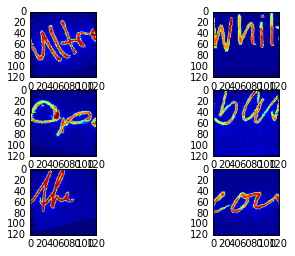

In [113]:
if False:
    (X_train, Y_train) = get_batch(author_hdf5_file, author_ids)
    X_train = 1.0 - X_train / 255.0
    X_train = np.expand_dims(X_train, 1)
    X_train = randangle(X_train)

plt.subplots(4,4)
for i in xrange(16):
    plt.subplot(3,2,i+1)
    plt.imshow(X_train[i][0])
print "number of authors = "+str(num_authors) + ", batch size = "+str(batch_size)